In [13]:
import os
import time
from queue import PriorityQueue

# Set paths for your Mac
data_dir = "/Users/xiaofengwu/Desktop/Project/data"
output_dir = "/Users/xiaofengwu/Desktop/Project/output"
os.makedirs(output_dir, exist_ok=True)

def read_input(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    n, m = map(int, lines[0].strip().split())
    sets = []
    for line in lines[1:]:
        parts = list(map(int, line.strip().split()))
        sets.append(set(parts[1:]))
    universe = set(range(1, n + 1))
    return universe, sets

def greedy_set_cover(universe, sets):
    uncovered = universe.copy()
    cover = []
    used_indices = set()
    while uncovered:
        best_index = max(
            range(len(sets)),
            key=lambda i: len(sets[i] & uncovered) if i not in used_indices else -1
        )
        best_set = sets[best_index]
        if not best_set & uncovered:
            break
        cover.append(best_index)
        uncovered -= best_set
        used_indices.add(best_index)
    return cover

def branch_and_bound(universe, sets, cutoff):
    start_time = time.time()
    best_solution = None
    best_cost = float('inf')
    trace = []

    greedy_solution = greedy_set_cover(universe, sets)
    upper_bound = len(greedy_solution)
    best_solution = greedy_solution[:]
    best_cost = upper_bound
    trace.append((0.0, best_cost))

    m = len(sets)
    queue = PriorityQueue()
    queue.put((0, [], set(), set(range(m))))  # (priority, selected, covered, undecided)

    MAX_QUEUE = 800000
    check_interval = 10000
    iteration = 0

    while not queue.empty() and time.time() - start_time < cutoff:
        iteration += 1
        if iteration % check_interval == 0:
            print(f"[{time.strftime('%H:%M:%S')}] Queue size: {queue.qsize()}")

        if queue.qsize() > MAX_QUEUE:
            continue

        lb, selected, covered, undecided = queue.get()

        if lb >= best_cost:
            continue

        if covered == universe:
            if len(selected) < best_cost:
                best_cost = len(selected)
                best_solution = selected[:]
                trace.append((time.time() - start_time, best_cost))
            continue

        if not undecided:
            continue

        i = next(iter(undecided))
        remaining = undecided - {i}

        # Include branch
        new_selected = selected + [i]
        new_covered = covered | sets[i]
        gain = len(sets[i] & (universe - covered))
        new_lb = len(new_selected)
        priority = new_lb - gain * 0.01  # favor higher gain

        if new_lb < best_cost and new_covered != covered and queue.qsize() < MAX_QUEUE:
            queue.put((priority, new_selected, new_covered, remaining))

        # Exclude branch
        if lb < best_cost and queue.qsize() < MAX_QUEUE:
            queue.put((lb, selected, covered, remaining))

    return best_solution, best_cost, trace


In [15]:
cutoff = 900  # 15 minutes
alg_name = "BnB"

for filename in os.listdir(data_dir):
    if filename.endswith(".in"):
        instance = filename[:-3]
        input_path = os.path.join(data_dir, filename)
        print(f"Processing {filename} at {time.strftime('%H:%M:%S')}...")

        universe, sets = read_input(input_path)
        start_time = time.time()
        solution, cost, trace = branch_and_bound(universe, sets, cutoff)
        elapsed_time = time.time() - start_time

        sol_path = os.path.join(output_dir, f"{instance}_{alg_name}_{cutoff}.sol")
        with open(sol_path, 'w') as f:
            f.write(f"{cost}\n")
            f.write(' '.join(map(str, sorted(solution))) + '\n')

        trace_path = os.path.join(output_dir, f"{instance}_{alg_name}_{cutoff}.trace")
        with open(trace_path, 'w') as f:
            for t, val in trace:
                f.write(f"{t:.2f} {val}\n")

        print(f"✔ Finished {filename} in {elapsed_time:.2f} seconds\n")


Processing test4.in at 17:32:26...
✔ Finished test4.in in 0.00 seconds

Processing test5.in at 17:32:26...
✔ Finished test5.in in 0.00 seconds

Processing small18.in at 17:32:26...
✔ Finished small18.in in 0.01 seconds

Processing test1.in at 17:32:26...
✔ Finished test1.in in 0.00 seconds

Processing small1.in at 17:32:26...
[17:32:26] Queue size: 3919
[17:32:26] Queue size: 1603
✔ Finished small1.in in 0.08 seconds

Processing large12.in at 17:32:26...
[17:32:26] Queue size: 9885
[17:32:26] Queue size: 19793
[17:32:26] Queue size: 29668
[17:32:27] Queue size: 39589
[17:32:27] Queue size: 49458
[17:32:27] Queue size: 59388
[17:32:27] Queue size: 69284
[17:32:27] Queue size: 79189
[17:32:27] Queue size: 89101
[17:32:27] Queue size: 98986
[17:32:27] Queue size: 108876
[17:32:27] Queue size: 118801
[17:32:27] Queue size: 128666
[17:32:42] Queue size: 138527
[17:32:42] Queue size: 148362
[17:32:42] Queue size: 158186
[17:32:42] Queue size: 167991
[17:32:43] Queue size: 177807
[17:32:43] Q

In [39]:
import pandas as pd
import os

def read_output_file(filepath):
    with open(filepath, 'r') as f:
        return int(f.readline().strip())

def read_solution_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    return int(lines[0].strip())

def read_trace_time(trace_path):
    try:
        with open(trace_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        if len(lines) >= 2:
            # BnB improved greedy — return time of last update
            last_line = lines[-1]
            return round(float(last_line.split()[0]), 6), False
        elif len(lines) == 1:
            # Only greedy was used
            return 0.0, True
    except:
        pass
    return None, None  # If something goes wrong

results = []

for filename in os.listdir(data_dir):
    if filename.endswith(".out") and (filename.startswith("small") or filename.startswith("large")):
        instance = filename[:-4]
        out_path = os.path.join(data_dir, filename)
        sol_path = os.path.join(output_dir, f"{instance}_{alg_name}_{cutoff}.sol")
        trace_path = os.path.join(output_dir, f"{instance}_{alg_name}_{cutoff}.trace")

        if not os.path.exists(sol_path):
            continue

        try:
            opt = read_output_file(out_path)
            collection_size = read_solution_file(sol_path)
            rel_err = round((collection_size - opt) / opt, 4)
            time_to_best, greedy_only = read_trace_time(trace_path)

            results.append({
                "Dataset": instance,
                "collection size": collection_size,
                "OPT": opt,
                "RelErr": rel_err,
                "Time to Best (s)": time_to_best if time_to_best is not None else "N/A",
                "Used Greedy Only": greedy_only
            })
        except:
            continue

# Sort results nicely
def sort_key(r):
    prefix = r["Dataset"][:5]
    num = int(''.join(filter(str.isdigit, r["Dataset"])))
    return (prefix, num)

results = sorted(results, key=sort_key)
df = pd.DataFrame(results)

# Format time for display
df["Time to Best (s)"] = df["Time to Best (s)"].map(lambda x: f"{x:.6f}" if isinstance(x, float) else x)

display(df)

# Save to CSV
df.to_csv(os.path.join(output_dir, "bnb_results_summary.csv"), index=False)


Dataset  collection size  OPT  RelErr Time to Best (s)  Used Greedy Only
0    large1               83   50  0.6600         0.000000              True
1    large2               21   19  0.1053         0.000000              True
2    large3               17   15  0.1333         0.000000              True
3    large4              153   91  0.6813         0.000000              True
4    large5                8    6  0.3333         0.000000              True
5    large6                7    6  0.1667         0.000000              True
6    large7              172   95  0.8105         0.000000              True
7    large8                6    5  0.2000         0.000000              True
8    large9               16   14  0.1429         0.000000              True
9   large10              319  221  0.4434         0.000000              True
10  large11               56   40  0.4000         0.000000              True
11  large12               18   15  0.2000         0.000000              True
12   small1                5    5  0.0000         0.000000              True
13   small2                3    3  0.0000         0.000000             False
14   small3                5    5  0.0000         0.010000             False
15   small4                4    4  0.0000         0.000000             False
16   small5                5    5  0.0000         2.190000             False
17   small6                3    3  0.0000         0.000000             False
18   small7                3    3  0.0000         0.000000             False
19   small8                2    2  0.0000         0.000000             False
20   small9                3    3  0.0000         0.000000             False
21  small10                2    2  0.0000         0.000000             False
22  small11                4    4  0.0000         0.020000             False
23  small12                3    3  0.0000         0.000000             False
24  small13                2    2  0.0000         0.000000             False
25  small14                2    2  0.0000         0.000000             False
26  small15                2    2  0.0000         0.000000             False
27  small16                2    2  0.0000         0.000000             False
28  small17                2    2  0.0000         0.000000             False
29  small18                2    2  0.0000         0.000000             False

In [41]:
import matplotlib.pyplot as plt

# X-axis: dataset names
large_datasets = ["large1", "large2", "large3", "large4", "large5", "large6", "large7",
                  "large8", "large9", "large10", "large11", "large12"]

small_datasets = ["small1", "small2", "small3", "small4", "small5", "small6", "small7",
                  "small8", "small9", "small10", "small11", "small12", "small13", "small14",
                  "small15", "small16", "small17", "small18"]


Matplotlib is building the font cache; this may take a moment.


In [43]:
# Example: Relative Error values (from LaTeX table) for Large
bnb_large =    [0.6600, 0.1053, 0.1333, 0.6813, 0.3333, 0.1667, 0.8105, 0.2000, 0.1429, 0.4434, 0.4000, 0.2000]
approx_large = [0.66,   0.11,   0.13,   0.68,   0.17,   0.00,   0.81,   0.00,   0.14,   0.44,   0.40,   0.20]
ls1_large =    [0.00,   0.11,   0.13,   0.67,   0.17,   0.00,   0.81,   0.00,   0.14,   0.44,   0.40,   0.20]
ls2_large =    [0.00,   0.05,   0.13,   0.67,   0.33,   0.17,   0.81,   0.20,   0.14,   0.43,   0.40,   0.20]

# Relative Error values for Small
bnb_small =    [0.00]*18
approx_small = [0.00, 0.33, 0.20, 0.25, 0.20, 0.33, 0.33, 0.50, 0.33, 0.50, 0.00, 0.33, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]
ls1_small =    [0.00, 0.00, 0.00, 0.00, 0.20, 0.33, 0.33, 0.50, 0.00, 0.00, 0.00, 0.33, 0.50, 0.50, 0.50, 0.50, 0.50, 0.00]
ls2_small =    [0.00, 0.33, 0.20, 0.25, 0.00, 0.33, 0.33, 0.50, 0.33, 0.50, 0.25, 0.33, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]


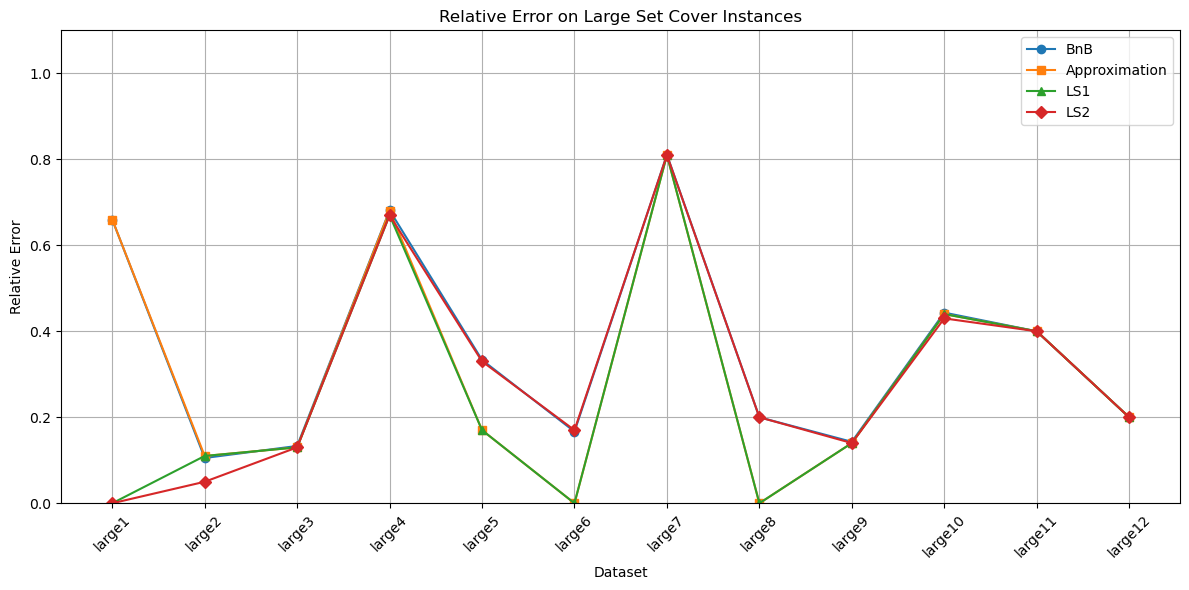

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(large_datasets, bnb_large, marker='o', label='BnB')
plt.plot(large_datasets, approx_large, marker='s', label='Approximation')
plt.plot(large_datasets, ls1_large, marker='^', label='LS1')
plt.plot(large_datasets, ls2_large, marker='D', label='LS2')

plt.title("Relative Error on Large Set Cover Instances")
plt.xlabel("Dataset")
plt.ylabel("Relative Error")
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


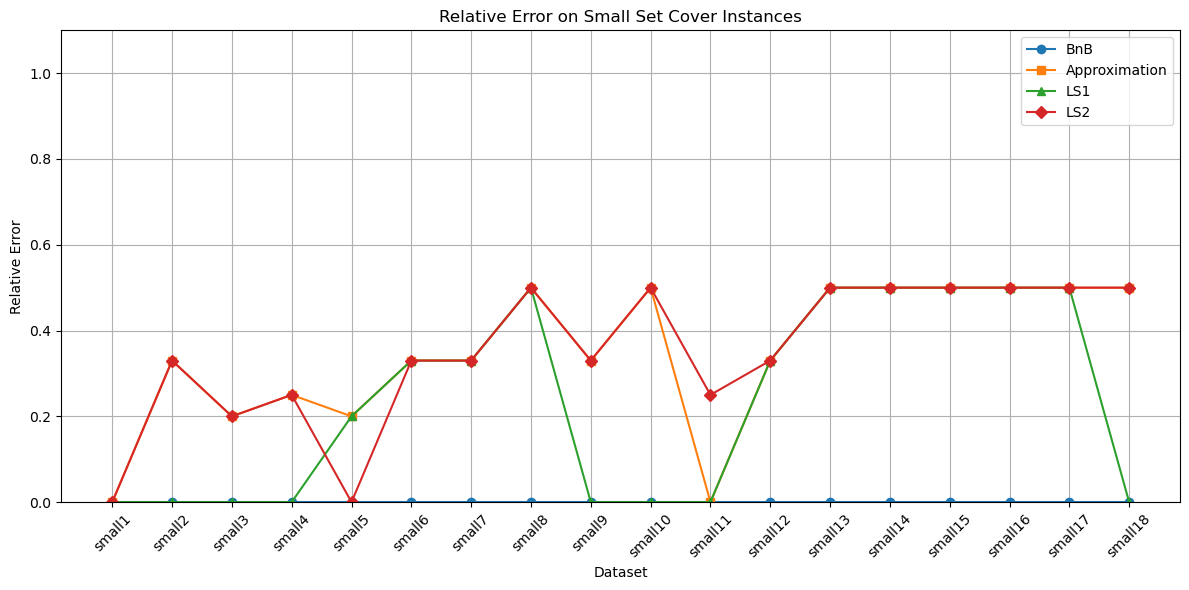

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(small_datasets, bnb_small, marker='o', label='BnB')
plt.plot(small_datasets, approx_small, marker='s', label='Approximation')
plt.plot(small_datasets, ls1_small, marker='^', label='LS1')
plt.plot(small_datasets, ls2_small, marker='D', label='LS2')

plt.title("Relative Error on Small Set Cover Instances")
plt.xlabel("Dataset")
plt.ylabel("Relative Error")
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [49]:
# Running times for Large datasets
bnb_time_large =    [0.00]*12
approx_time_large = [0.00]*12
ls1_time_large =    [0.31, 0.00, 0.00, 0.11, 0.00, 0.00, 0.00, 0.00, 0.00, 0.74, 0.00, 0.00]
ls2_time_large =    [1.69, 0.00, 0.00, 0.26, 0.00, 0.00, 0.00, 0.00, 0.00, 6.76, 0.00, 0.00]

# Running times for Small datasets
bnb_time_small =    [0.00, 0.00, 0.01, 0.00, 2.19, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
approx_time_small = [0.00]*18
ls1_time_small =    [0.00]*18
ls2_time_small =    [0.00]*18


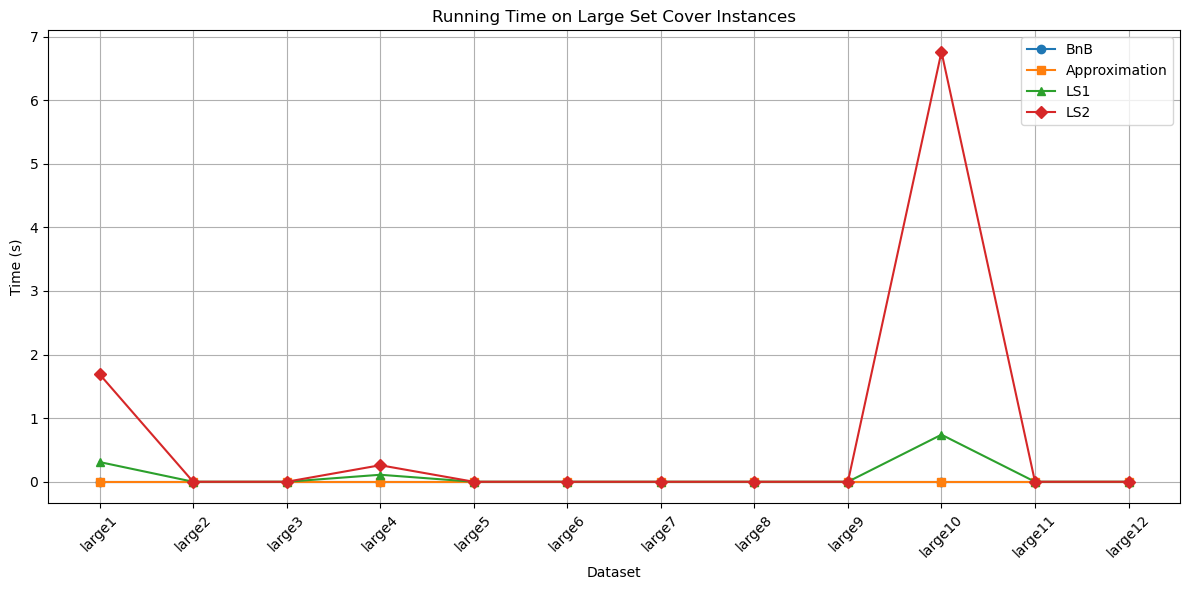

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(large_datasets, bnb_time_large, marker='o', label='BnB')
plt.plot(large_datasets, approx_time_large, marker='s', label='Approximation')
plt.plot(large_datasets, ls1_time_large, marker='^', label='LS1')
plt.plot(large_datasets, ls2_time_large, marker='D', label='LS2')

plt.title("Running Time on Large Set Cover Instances")
plt.xlabel("Dataset")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


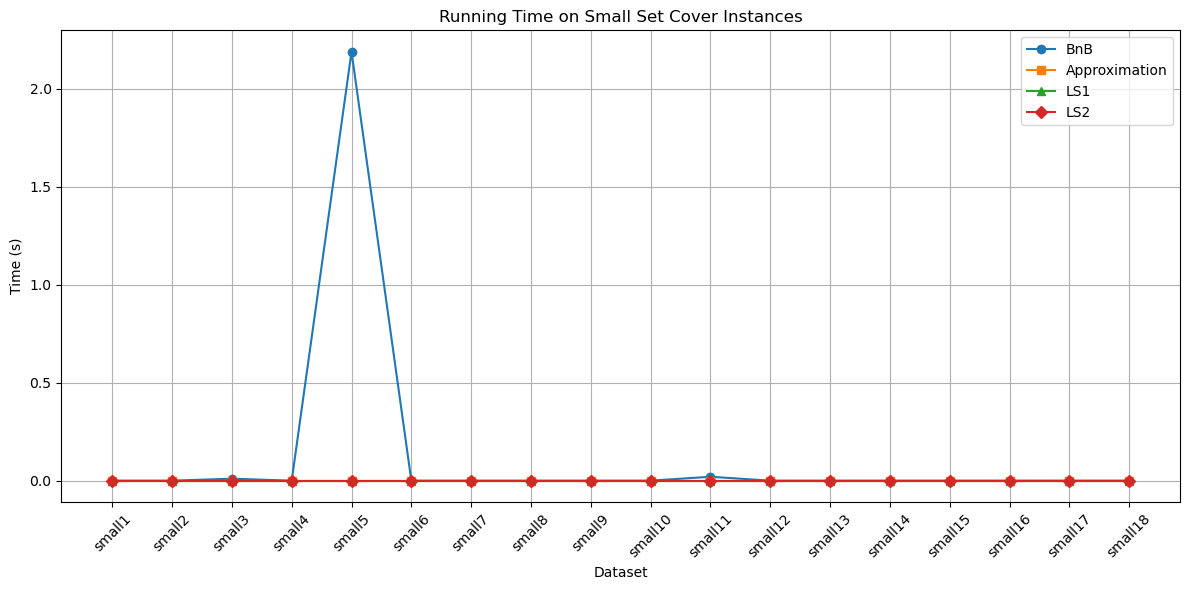

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(small_datasets, bnb_time_small, marker='o', label='BnB')
plt.plot(small_datasets, approx_time_small, marker='s', label='Approximation')
plt.plot(small_datasets, ls1_time_small, marker='^', label='LS1')
plt.plot(small_datasets, ls2_time_small, marker='D', label='LS2')

plt.title("Running Time on Small Set Cover Instances")
plt.xlabel("Dataset")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
